In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Lasso

from keras.utils.np_utils import to_categorical
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from keras.models import Model
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

In [2]:
#https://github.com/IBM/xgboost-smote-detect-fraud

url = "https://raw.githubusercontent.com/dnishimoto/python-deep-learning/master/creditcard.csv"

creditcard = pd.read_csv(url)
print(creditcard.shape)
print(creditcard.columns)

(56874, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [3]:
creditcard.columns = [x.lower() for x in creditcard.columns]
creditcard.rename(columns = {'class': 'fraud'}, inplace = True)
print(creditcard.fraud.value_counts(dropna = False))

X = creditcard.drop("fraud", axis = 1)
y = creditcard["fraud"]



0    56772
1      102
Name: fraud, dtype: int64


In [5]:
standardized_data = StandardScaler().fit_transform(creditcard)

C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


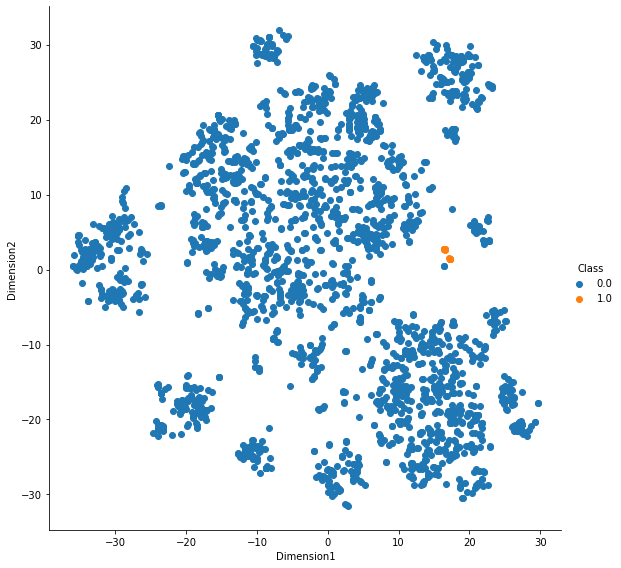

In [7]:
data_2k = standardized_data[0:2500]
labels_2k = y[0:2500]

model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=400)

tsne_data = model.fit_transform(data_2k)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension1", "Dimension2", "Class"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Class", size=8).map(plt.scatter, 'Dimension1', 'Dimension2').add_legend()
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, stratify = y, random_state = 42)
lr = LogisticRegression(verbose = 3, warm_start = True)
lr.fit(X_train, y_train) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


LogisticRegression(verbose=3, warm_start=True)

Text(0, 0.5, 'TPR')

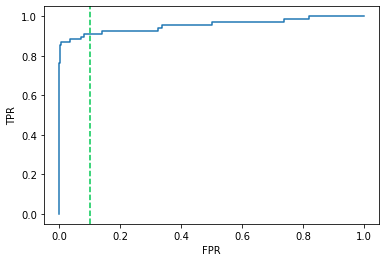

In [10]:
y_train_pred_probas = lr.predict_proba(X_train)[:, 1]   # prob of predict as 1
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_probas)   # precision_recall_curve
roc = pd.DataFrame({'FPR':fpr,'TPR':tpr,'Thresholds':thresholds})

_ = plt.figure()
plt.plot(roc.FPR, roc.TPR)
plt.axvline(0.1, color = '#00C851', linestyle = '--')
plt.xlabel("FPR")
plt.ylabel("TPR")

Predicted fraud count  30


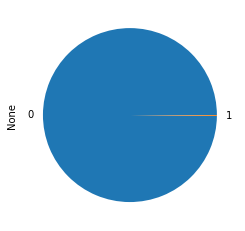

[[18727     8]
 [   12    22]]
Accuracy is %s 99.89344131280302


In [11]:
y_pred=lr.predict(X_test)

print("Predicted fraud count ",len(y_pred[y_pred==1]))
buffer=pd.Series(y_pred)
buffer.value_counts().plot(kind='pie')
plt.show()

print(confusion_matrix(y_test,y_pred))
# true positive     true negative
# false negative    false positive
print("Accuracy is %s",lr.score(X_test,y_test)*100)

Text(0.5, 257.44, 'Predicted label')

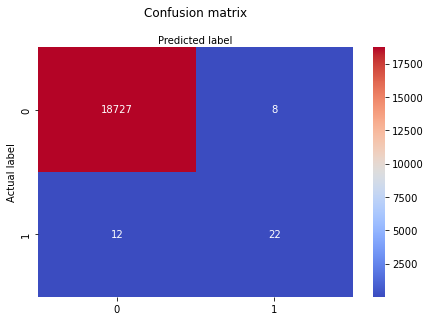

In [12]:
confusion_matrix = confusion_matrix(y_test, y_pred)

class_names=[1,2,3]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="coolwarm" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

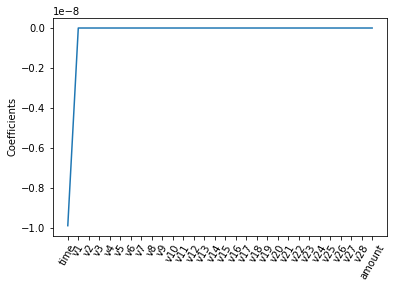

In [13]:
column_names=creditcard.columns[0:30]
lasso=Lasso(alpha=0.1)
lasso_coef=lasso.fit(X,y).coef_

_ = plt.plot(range(len(column_names)),lasso_coef)
_ = plt.xticks(range(len(column_names)),column_names,rotation=60)
_ = plt.ylabel('Coefficients')
plt.show()

In [14]:
#https://songhuiming.github.io/pages/2018/05/05/credit-card-fraud-detection-imbalanced-data-modeling-part-i-logistic-regression/

#over sampling to improve efficiency

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


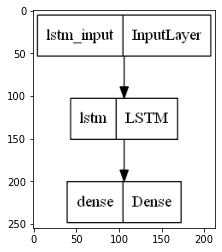

In [15]:
model=Sequential()

model.add(Dense(len(column_names), input_dim=len(column_names), activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

early_stopping_monitor=EarlyStopping(patience=3)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])


plot_model(model, to_file='model.png')
img=plt.imread('model.png')
plt.imshow(img)
plt.show()

In [16]:
scalar = MinMaxScaler()
scalar.fit(X)
X_scaled = scalar.transform(X)

model.fit(X_scaled, y,callbacks=[early_stopping_monitor],  epochs=10)

Epoch 1/10
1778/1778 [==============================] - 2s 1ms/step - loss: 0.0222 - accuracy: 0.9981
Epoch 2/10
1778/1778 [==============================] - 2s 1ms/step - loss: 0.0076 - accuracy: 0.9984
Epoch 3/10
1778/1778 [==============================] - 2s 1ms/step - loss: 0.0047 - accuracy: 0.9989
Epoch 4/10
1778/1778 [==============================] - 2s 1ms/step - loss: 0.0037 - accuracy: 0.9992
Epoch 5/10
1778/1778 [==============================] - 2s 1ms/step - loss: 0.0033 - accuracy: 0.9993
Epoch 6/10
1778/1778 [==============================] - 2s 1ms/step - loss: 0.0032 - accuracy: 0.9993
Epoch 7/10
1778/1778 [==============================] - 2s 1ms/step - loss: 0.0031 - accuracy: 0.9994
Epoch 8/10
1778/1778 [==============================] - 3s 1ms/step - loss: 0.0030 - accuracy: 0.9994
Epoch 9/10
1778/1778 [==============================] - 2s 1ms/step - loss: 0.0030 - accuracy: 0.9994
Epoch 10/10
1778/1778 [==============================] - 2s 1ms/step - loss: 0.002

1778/1778 [==============================] - 1s 726us/step
84
56790


<function matplotlib.pyplot.show(close=None, block=None)>

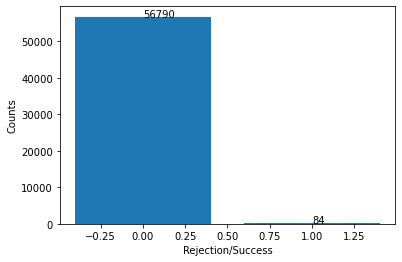

In [17]:
y_pred=model.predict(X_scaled)
buffer=y_pred.flatten()
#print(buffer)
yes=buffer[buffer>=.5]
no=buffer[buffer<.5]
print(len(yes))
print(len(no))

counts=[len(no),len(yes)]
plt.bar(range(2),counts)
plt.ylabel("Counts")
plt.xlabel("Rejection/Success")

plt.annotate(str(len(no)), xy=(0,len(no)))
plt.annotate(str(len(yes)), xy=(1,len(yes)))

plt.show